In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
import urllib.request
import zipfile
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.models import Sequential,Model
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data_url = 'https://drive.usercontent.google.com/download?id=1RykmQsicNSuTgzeSWd1uNYW59v-LJ6AJ&export=download&confirm=t'
urllib.request.urlretrieve(data_url, 'Datasets.zip') #testing beberapa sudah terfilter
local_zip = 'Datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Datasets')
zip_ref.close()

base_dir = 'Datasets'

In [ ]:
train_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/train")
val_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/validation")
test_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/test")

# ImageDataGenerator untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,       # Normalisasi gambar ke rentang [0, 1]
    rotation_range=30,       # Augmentasi: rotasi acak gambar hingga 40 derajat #asli 30
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,         # Augmentasi: aplikasi transformasi geser
    zoom_range=0.2,          # Augmentasi: zoom gambar hingga 20%
    horizontal_flip=True,    # Augmentasi: flip gambar secara horizontal
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=256,
    class_mode='categorical'
)

# ImageDataGenerator untuk validasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=128,  #Ganti 64
    class_mode='categorical'
)

# ImageDataGenerator untuk testing
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=128, #Ganti 64
    class_mode='categorical'
)

Found 1062 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
#Load Model
model = load_model('best_InceptionV3_model_fix.h5')

1/1 [==============================] - 0s 187ms/step
HASIL PREDIKSI : BAGUS
BAGUS: 76.53%
RUSAK BERAT: 0.05%
RUSAK RINGAN: 23.42%


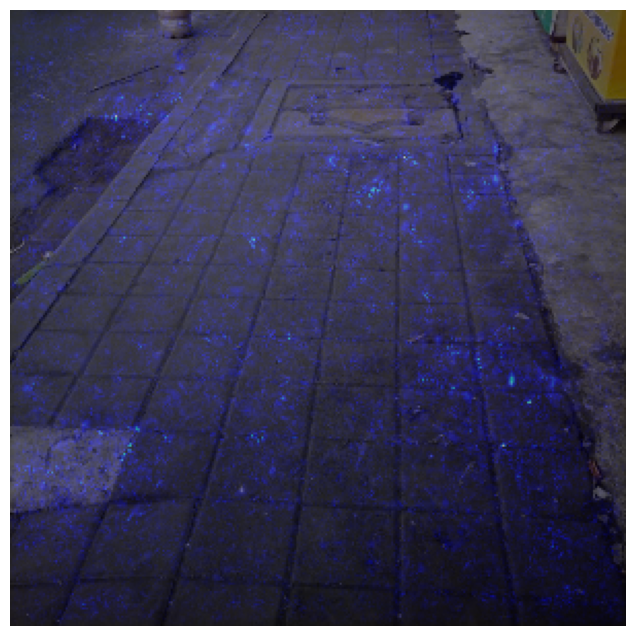

In [ ]:
# read the image
img = cv2.imread('bagus3.jpg')

# Class Index
# BAGUS : 0
# RUSAK BERAT : 1
# RUSAK RINGAN : 2
class_index = 0

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (299, 299)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

# number of classes in the model's training data
num_classes = 3

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to floata
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)

gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

class_list = ["BAGUS", "RUSAK BERAT", "RUSAK RINGAN"]
predictions = model.predict(image)
print(f"HASIL PREDIKSI : {class_list[np.argmax(predictions )]}")
for class_name, prob in zip(class_list, predictions.flatten()):
    print(f"{class_name}: {float(prob) * 100:.2f}%")

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()



